In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#Preprocessing methods
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
import itertools
import time
import statsmodels.api as sm

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


#Data Preprocessing

In [ ]:
#load dataset
appliances_energy = "/content/drive/MyDrive/energydata_complete.csv"
df = pd.read_csv(appliances_energy)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
#check for missing values
pd.DataFrame({'percent_missing':df.isna().sum()*100/len(df)})

,percent_missing
date,0.0
Appliances,0.0
lights,0.0
T1,0.0
RH_1,0.0
T2,0.0
RH_2,0.0
T3,0.0
RH_3,0.0
T4,0.0


In [ ]:
#data preprocessing including: drop random variables, change 'date' to 'month' 'weekend' and 'night', 
df['date'] = pd.to_datetime(df['date'])

df = df.drop(columns=['rv1', 'rv2'])

df['month'] = pd.DatetimeIndex(df['date']).month
df['dayofweek'] = pd.DatetimeIndex(df['date']).dayofweek
df['hour'] = pd.DatetimeIndex(df['date']).hour

def categorize_weekend(row):
  if row['dayofweek'] >= 5:
    return 1
  else:
    return 0

df['weekend'] = df.apply(lambda row: categorize_weekend(row), axis = 1)


def categorize_night(row):
  if row['hour'] <= 7:
    return 1
  elif row['hour'] >= 23:
    return 1
  else:
    return 0
  
df['night'] = df.apply(lambda row: categorize_night(row), axis = 1)

df = df.drop(columns=['dayofweek', 'hour', 'date'])

# Exploratory Data Analysis

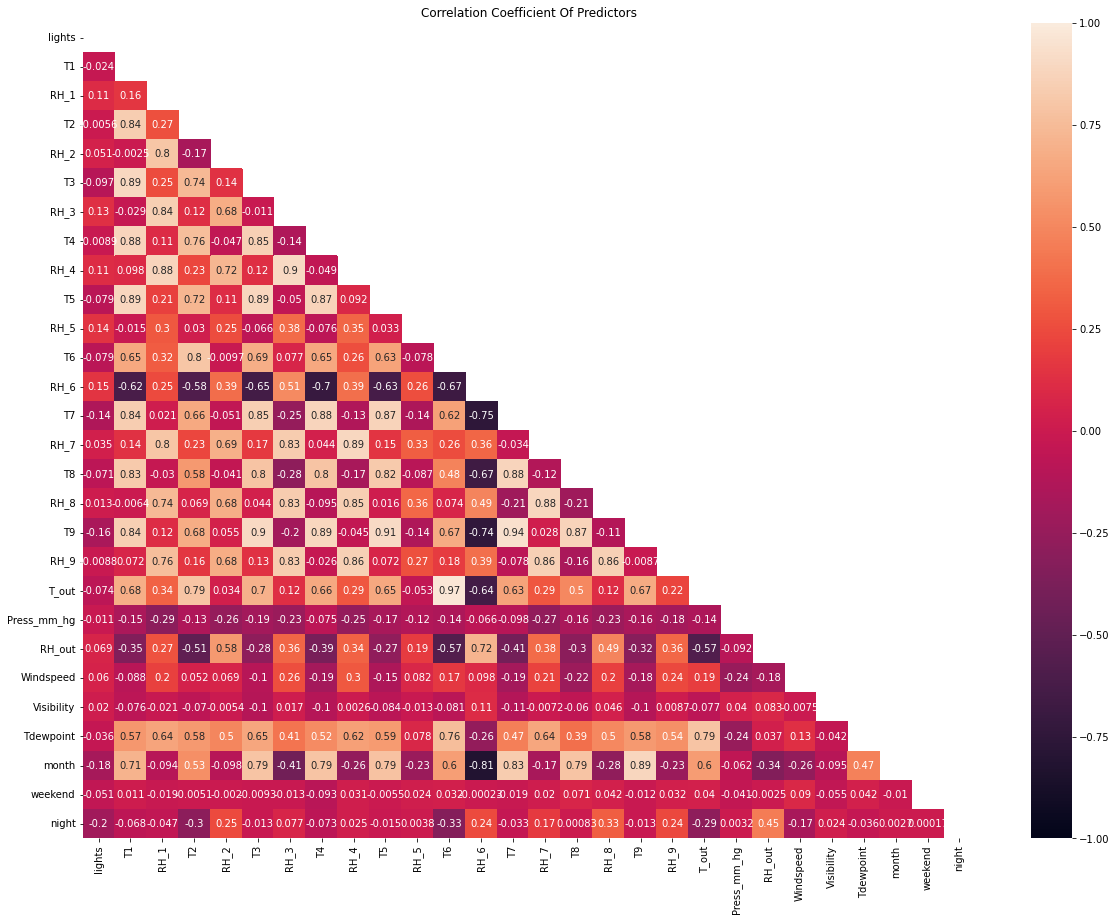

In [ ]:
#correlation heatmap for all variables without aggregation
plt.figure(figsize=(20,15))

mask = np.triu(np.ones_like(df.loc[:, df.columns != 'Appliances'].corr(), dtype=bool))

sns.heatmap(df.loc[:, df.columns != 'Appliances'].corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

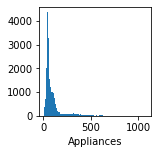

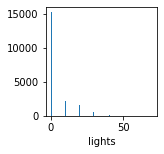

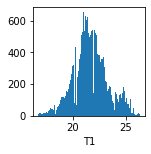

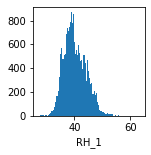

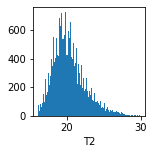

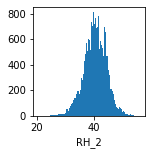

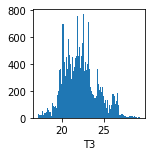

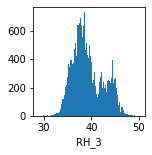

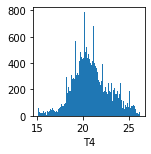

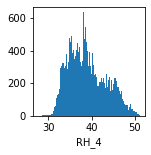

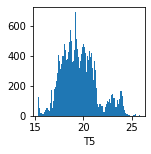

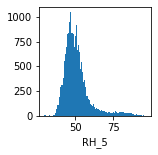

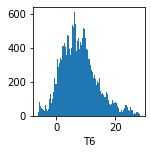

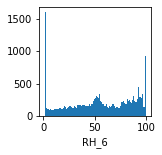

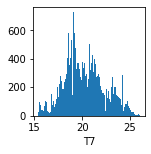

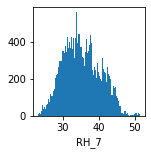

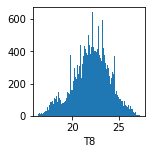

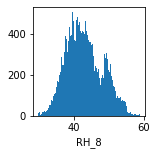

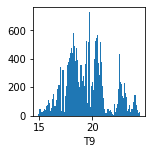

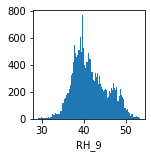

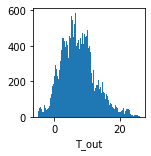

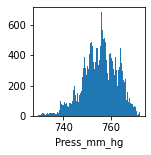

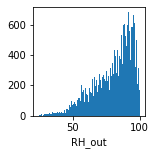

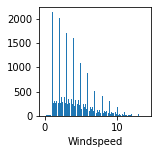

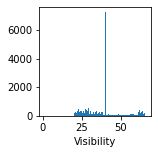

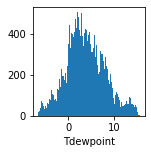

In [ ]:
#distribution of all variables
no_of_columns = len(df.columns)

plt.rcParams["figure.figsize"] = [2,2]  #set the graph to a smaller size 
#no_of_columns = 3                # in-case you want to try with a smaller subset of graphs to save execution time / CPU consumption
for i in range(0,no_of_columns - 5) :
    col_name = df.columns[i]  # get the column name to identify the graph
    x=df[col_name]
    plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
    k=plt.hist(x,bins=100)       # Change the right number of bins to get it more/less granular 
    plt.show()

In [ ]:
#isolate internal temperature variables
temp_cols = df[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']]
temp_cols

,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,19.890000,19.200000,19.790000,19.000000,17.166667,7.026667,17.200000,18.2000,17.033333
1,19.890000,19.200000,19.790000,19.000000,17.166667,6.833333,17.200000,18.2000,17.066667
2,19.890000,19.200000,19.790000,18.926667,17.166667,6.560000,17.200000,18.2000,17.000000
3,19.890000,19.200000,19.790000,18.890000,17.166667,6.433333,17.133333,18.1000,17.000000
4,19.890000,19.200000,19.790000,18.890000,17.200000,6.366667,17.200000,18.1000,17.000000
...,...,...,...,...,...,...,...,...,...
19730,25.566667,25.890000,27.200000,24.700000,23.200000,24.796667,24.500000,24.7000,23.200000
19731,25.500000,25.754000,27.133333,24.700000,23.230000,24.196667,24.557143,24.7000,23.200000
19732,25.500000,25.628571,27.050000,24.700000,23.230000,23.626667,24.540000,24.7000,23.200000
19733,25.500000,25.414000,26.890000,24.700000,23.200000,22.433333,24.500000,24.6625,23.200000


In [ ]:
#standardize internal temperature variables
temp_pca = temp_cols

sc = StandardScaler()
temp_pca = sc.fit_transform(temp_pca)

In [ ]:
#conduct PCA to aggregate internal temperature variables
from numpy import array, dot, mean, std, empty, argsort
from numpy.linalg import eigh, solve
from numpy.random import randn
from matplotlib.pyplot import subplots, show

def cov(X):
    return dot(X.T, X) / X.shape[0]
    # N = data.shape[1]
    # C = empty((N, N))
    # for j in range(N):
    #   C[j, j] = mean(data[:, j] * data[:, j])
    #   for k in range(j + 1, N):
    #       C[j, k] = C[k, j] = mean(data[:, j] * data[:, k])
    # return C

def pca(data, pc_count = None):
    data -= mean(data, 0)
    data /= std(data, 0)
    C = cov(data)
    E, V = eigh(C)
    key = argsort(E)[::-1][:pc_count]
    E, V = E[key], V[:, key]
    U = dot(data, V)  # used to be dot(V.T, data.T).T
    return U, E, V

In [ ]:
temp_trans = pca(temp_pca, 3)[0]

In [ ]:
principal_temp_df = pd.DataFrame(temp_trans, columns = ['PC1_temp', 'PC2_temp', 'PC3_temp'])

In [ ]:
principal_temp_df

,PC1_temp,PC2_temp,PC3_temp
0,-3.350895,-1.235036,-0.074906
1,-3.353890,-1.211129,-0.062191
2,-3.390420,-1.189659,-0.029440
3,-3.429815,-1.205518,-0.010981
4,-3.415684,-1.188406,-0.011938
...,...,...,...
19730,6.351259,-1.422077,-0.084849
19731,6.293915,-1.315650,-0.082903
19732,6.233229,-1.226783,-0.052809
19733,6.102859,-1.062777,0.019793


In [ ]:
df_pca = pd.concat([df.reset_index(drop=True),principal_temp_df.reset_index(drop=True)], axis=1)

In [ ]:
#isolate internal humidity variables
rh_cols = df[['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']]
rh_cols

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9
0,47.596667,44.790000,44.730000,45.566667,55.200000,84.256667,41.626667,48.900000,45.5300
1,46.693333,44.722500,44.790000,45.992500,55.200000,84.063333,41.560000,48.863333,45.5600
2,46.300000,44.626667,44.933333,45.890000,55.090000,83.156667,41.433333,48.730000,45.5000
3,46.066667,44.590000,45.000000,45.723333,55.090000,83.423333,41.290000,48.590000,45.4000
4,46.333333,44.530000,45.000000,45.530000,55.090000,84.893333,41.230000,48.590000,45.4000
...,...,...,...,...,...,...,...,...,...
19730,46.560000,42.025714,41.163333,45.590000,52.400000,1.000000,44.500000,50.074000,46.7900
19731,46.500000,42.080000,41.223333,45.590000,52.326667,1.000000,44.414286,49.790000,46.7900
19732,46.596667,42.768571,41.690000,45.730000,52.266667,1.000000,44.400000,49.660000,46.7900
19733,46.990000,43.036000,41.290000,45.790000,52.200000,1.000000,44.295714,49.518750,46.8175


In [ ]:
#standardize internal humidity variables
rh_pca = rh_cols

sc = StandardScaler()
rh_pca = sc.fit_transform(rh_pca)

In [ ]:
#conduct PCA to aggregate internal humidity variables
rh_trans = pca(rh_pca, 3)[0]

In [ ]:
principal_rh_df = pd.DataFrame(rh_trans, columns = ['PC1_rh', 'PC2_rh', 'PC3_rh'])

In [ ]:
df_pca = pd.concat([df_pca.reset_index(drop=True),principal_rh_df.reset_index(drop=True)], axis=1)

In [ ]:
df_pca = df_pca.drop(columns=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9','RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'PC2_temp', 'PC3_temp', 'PC2_rh', 'PC3_rh'])

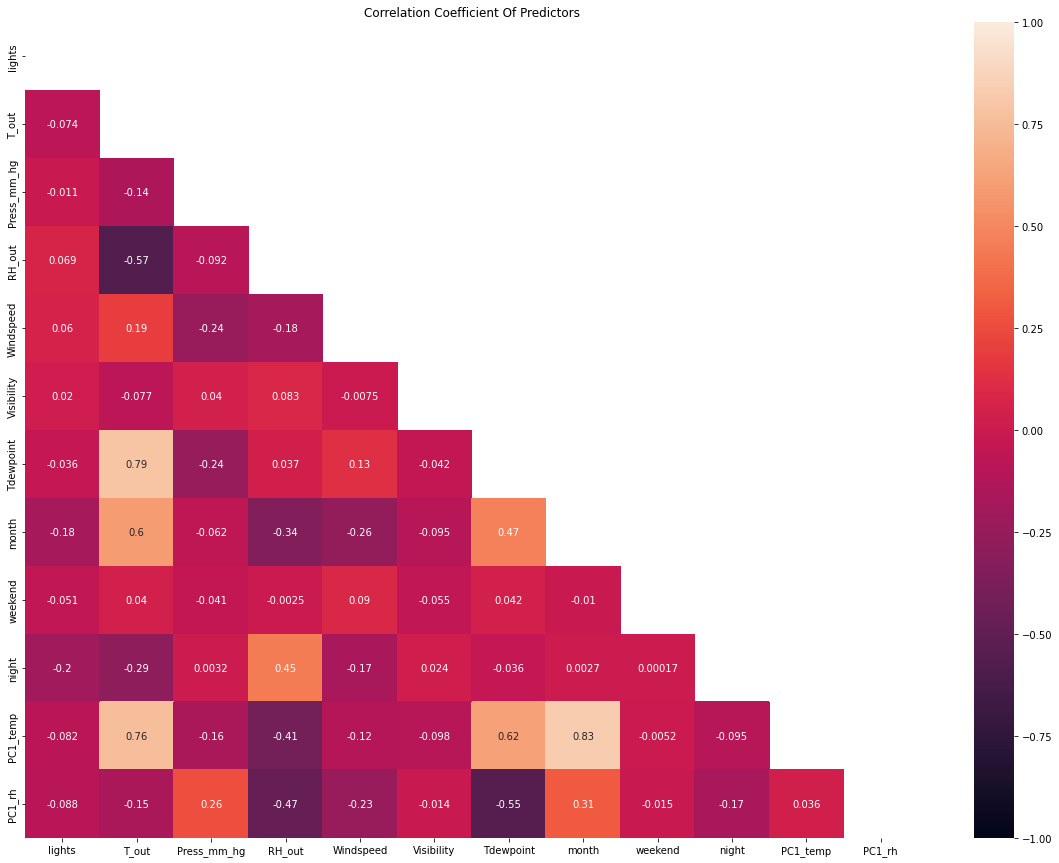

In [ ]:
#correlation heatmap for variables after using PCA to aggregate internal temperature and humidity variables
plt.figure(figsize=(20,15))

mask = np.triu(np.ones_like(df_pca.loc[:, df_pca.columns != 'Appliances'].corr(), dtype=bool))

sns.heatmap(df_pca.loc[:, df_pca.columns != 'Appliances'].corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

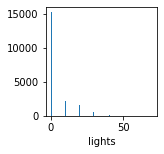

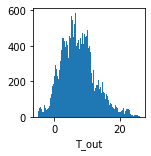

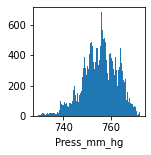

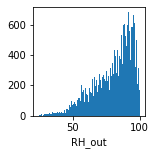

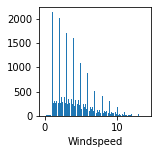

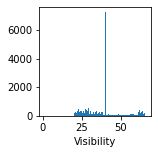

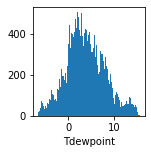

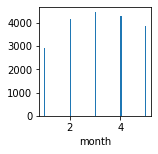

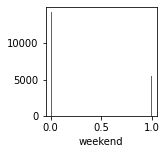

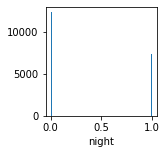

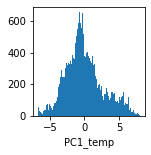

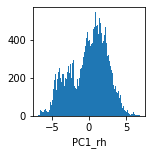

In [ ]:
#distribution for all variables after PCA aggregation
no_of_columns = len(df_pca.columns)

plt.rcParams["figure.figsize"] = [2,2]  #set the graph to a smaller size 
#no_of_columns = 5                # in-case you want to try with a smaller subset of graphs to save execution time / CPU consumption
for i in range(1,no_of_columns) :
    col_name = df_pca.columns[i]  # get the column name to identify the graph
    x=df_pca[col_name]
    plt.xlabel(col_name)         # The column name will be the x-label ( just to identify )
    k=plt.hist(x,bins=100)       # Change the right number of bins to get it more/less granular 
    plt.show()

In [ ]:
y = df['Appliances'].values

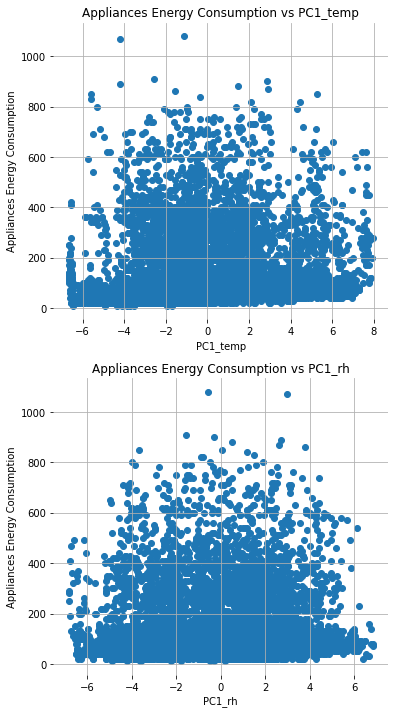

In [ ]:
#relationship between PC1 components of temperature and humidity on appliances energy consumption
fig, ax = plt.subplots(2, figsize=(6, 12))


ax[0].scatter(temp_trans[:,0],y)
ax[0].set_xlabel("PC1_temp")
ax[0].set_ylabel("Appliances Energy Consumption")
ax[0].set_frame_on(False)
ax[0].grid(True)
ax[0].set_title('Appliances Energy Consumption vs PC1_temp')

ax[1].scatter(rh_trans[:,0],y)
ax[1].set_xlabel("PC1_rh")
ax[1].set_ylabel("Appliances Energy Consumption")
ax[1].set_title('Appliances Energy Consumption vs PC1_rh')
ax[1].grid(True)
ax[1].set_frame_on(False)

In [ ]:
#aggregating internal temperature and humidity variables using simple average
df_average = df

df_average['average_in_temp'] = temp_cols.mean(axis=1)
df_average['average_in_rh'] = rh_cols.mean(axis=1)

df_average = df_average.drop(columns=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9','RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9'])

In [ ]:
df_average

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month,weekend,night,average_in_temp,average_in_rh
0,60,30,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,1,0,0,17.167407,50.910741
1,60,30,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,1,0,0,17.149630,50.827222
2,50,30,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,1,0,0,17.103704,50.628889
3,50,40,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,1,0,0,17.067037,50.574815
4,60,40,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,1,0,0,17.070741,50.732963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,5,0,0,24.861481,41.122561
19731,90,0,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,5,0,0,24.774571,41.079365
19732,270,10,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,5,0,0,24.686138,41.211323
19733,420,10,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,5,0,0,24.499981,41.215329


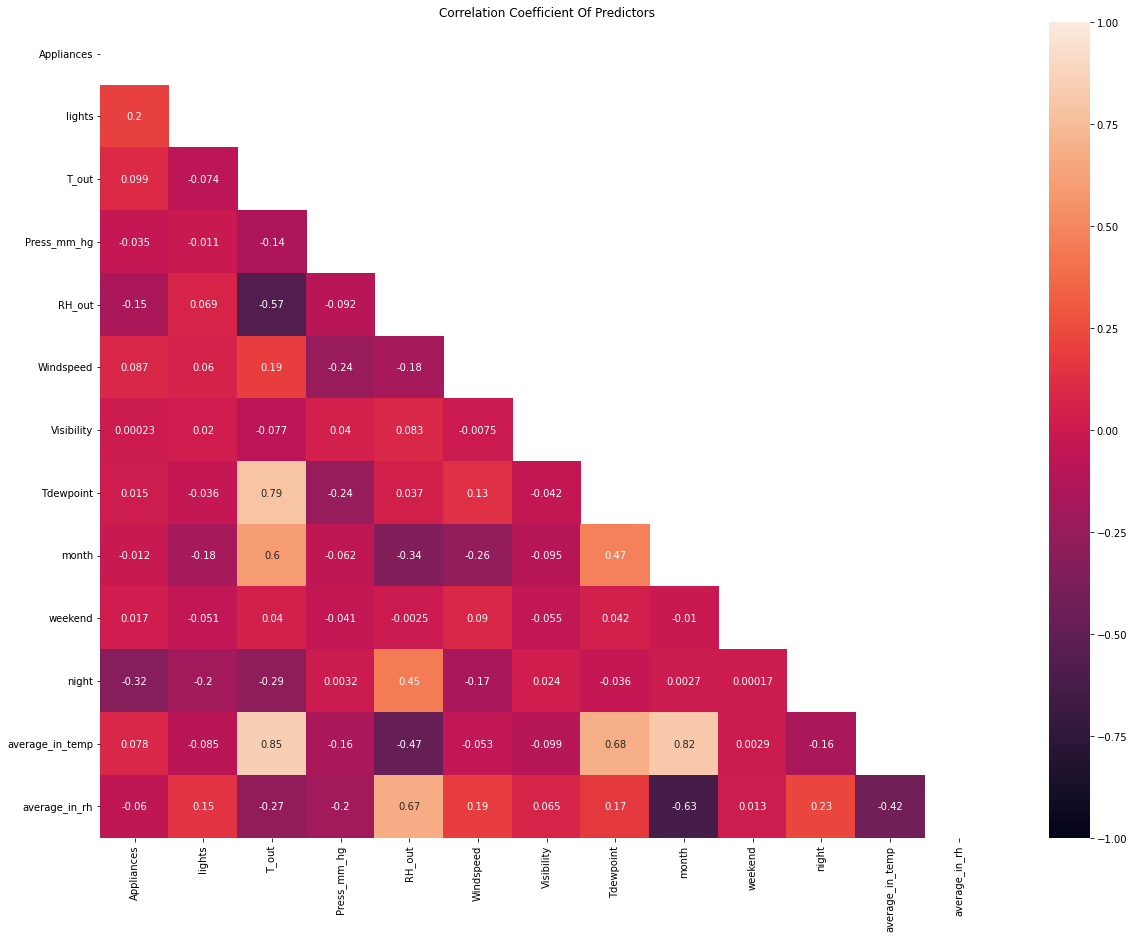

In [ ]:
#correlation heatmap for all variables after aggregation using simple average
plt.figure(figsize=(20,15))

mask = np.triu(np.ones_like(df_average.corr(), dtype=bool))

sns.heatmap(df_average.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [ ]:
df_average[:,11]

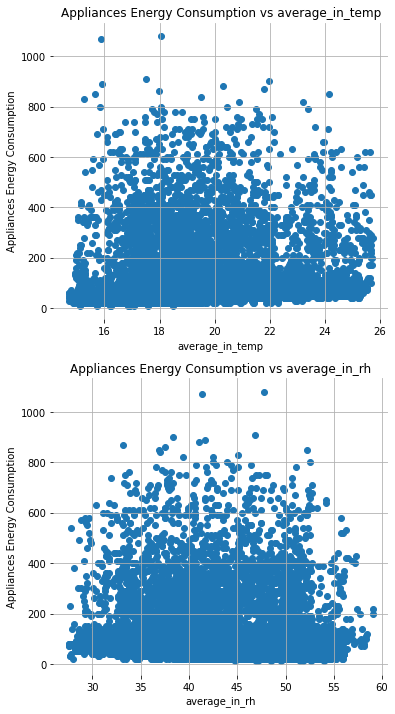

In [ ]:
#distribution of all variables after aggregation using simple average
fig, ax = plt.subplots(2, figsize=(6, 12))


ax[0].scatter(df_average.iloc[:,11],y)
ax[0].set_xlabel("average_in_temp")
ax[0].set_ylabel("Appliances Energy Consumption")
ax[0].set_frame_on(False)
ax[0].grid(True)
ax[0].set_title('Appliances Energy Consumption vs average_in_temp')

ax[1].scatter(df_average.iloc[:,12],y)
ax[1].set_xlabel("average_in_rh")
ax[1].set_ylabel("Appliances Energy Consumption")
ax[1].set_title('Appliances Energy Consumption vs average_in_rh')
ax[1].grid(True)
ax[1].set_frame_on(False)

# Data Modeling

In [ ]:
# Calculating the r² accuracy of our model
def r2score(predicted, actual):
  rss = 0.0
  tss = 0.0
  actual_mean = sum(actual)/(float(len(actual)))
  for i in range(len(actual)):
    rss += ((predicted[i]-actual[i])**2)
    tss += ((actual[i]-actual_mean)**2)

  r2 = 1 - (rss/tss)
  return r2

In [ ]:
# Calculating the RMSE accuracy of our model
from math import sqrt
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return sqrt(mean_error)

In [ ]:
print(df.keys())

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'month', 'weekend', 'night', 'average_in_temp',
       'average_in_rh'],
      dtype='object')


In [ ]:
#standardize numerical variables
from sklearn.compose import ColumnTransformer

col_names = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'month', 'weekend', 'night', 'average_in_temp',
       'average_in_rh']
features = df[col_names]

ct = ColumnTransformer([
        ('normalize_numeric', StandardScaler(), ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'average_in_temp','average_in_rh'])
    ], remainder='passthrough')

df_scaled = ct.fit_transform(features)
df_scaled = pd.DataFrame(df_scaled, columns = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'average_in_temp','average_in_rh', 'month', 'weekend', 'night'])

In [ ]:
from sklearn.model_selection import train_test_split


X_scaled = df_scaled.iloc[:, 1:].values
y_scaled = df_scaled.iloc[:, 0].values


#split training and testing data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## Lasso Regression

In [ ]:
#Lasso Regression
class LassoRegression() :      
    def __init__( self, learning_rate, iterations, l1_penality ) :        
        self.learning_rate = learning_rate        
        self.iterations = iterations       
        self.l1_penality = l1_penality
          
    # Function for model training
              
    def fit(self, X, y) :        
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.y = y
          
        # gradient descent learning
                  
        for i in range(self.iterations) :       
            self.update_weights()     
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights(self) :    
        y_pred = self.predict(self.X)   
        # calculate gradients      
        dW = np.zeros( self.n )  
        for j in range( self.n ) :  
            if self.W[j] > 0 :  
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.y - y_pred ) )          
                         + self.l1_penality ) / self.m
            else :
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.y - y_pred ) ) 
                         - self.l1_penality ) / self.m
  
       
        db = - 2 * np.sum(self.y - y_pred) / self.m 
        # update weights
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        return self
      
    # Hypothetical function  h( x ) 
    def predict(self, X) :
        return X.dot(self.W) + self.b

In [ ]:
#r2 score for training data
lasso = LassoRegression( iterations = 1000, learning_rate = 0.01, l1_penality = 500 )
lasso.fit(X_train_scaled, y_train_scaled)
y_preds_train_lasso = lasso.predict(X_train_scaled)


r2score(y_preds_train_lasso, y_train_scaled)

0.15923997681919277

In [ ]:
#rmse for training data
rmse_metric(y_train_scaled, y_preds_train_lasso)

0.9223922110850198

In [ ]:
#r2score for testing data
y_preds_test_lasso = lasso.predict(X_test_scaled)


r2score(y_preds_test_lasso, y_test_scaled)

0.1634910540243404

In [ ]:
#rmse for testing data
rmse_metric(y_test_scaled, y_preds_test_lasso)

0.8924233206394819

In [ ]:
#feature importance for lasso regression
lasso.W

array([ 1.30087142e-01, -4.07345959e-05,  1.74927725e-01, -2.21965306e-04,
       -7.64576167e-02,  2.19586144e-01,  2.39106792e-02, -5.96379581e-02,
        5.93699192e-05, -4.69280315e-02, -1.79810533e-04, -1.07037371e-04,
       -2.74781349e-04, -4.21882899e-05, -9.02546381e-02, -2.54387959e-05,
       -4.23593942e-02, -4.53934082e-02,  5.11679643e-05,  1.37624052e-05,
        2.28461781e-05, -5.39978720e-04,  1.93640927e-02,  3.04996302e-04,
       -2.69056869e-02, -2.58339018e-04, -3.01284542e-04, -4.76841120e-03,
        1.26824701e-04, -4.16457818e-01])

##Decision Tree

In [ ]:
#decision tree
import math


def divide_on_feature(X, feature_i, threshold):
    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])

def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


class DecisionNode():
    """Class that represents a decision node or leaf in the decision tree
    Parameters:
    -----------
    feature_i: int
        Feature index which we want to use as the threshold measure.
    threshold: float
        The value that we will compare feature values at feature_i against to
        determine the prediction.
    value: float
        The class prediction if classification tree, or float value if regression tree.
    true_branch: DecisionNode
        Next decision node for samples where features value met the threshold.
    false_branch: DecisionNode
        Next decision node for samples where features value did not meet the threshold.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          # Index for the feature that is tested
        self.threshold = threshold          # Threshold value for feature
        self.value = value                  # Value if the node is a leaf in the tree
        self.true_branch = true_branch      # 'Left' subtree
        self.false_branch = false_branch    # 'Right' subtree
  

class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.
    Parameters:
    -----------
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    loss: function
        Loss function that is used for Gradient Boosting models to calculate impurity.
    """
    def __init__(self, min_samples_split=500, min_impurity=1e-7,
                 max_depth=20, loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""

        largest_impurity = 0
        best_criteria = None    # Feature index and threshold
        best_sets = None        # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._impurity_calculation(y, y1, y2)

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X of left subtree
                                "lefty": Xy1[:, n_features:],   # y of left subtree
                                "rightX": Xy2[:, :n_features],  # X of right subtree
                                "righty": Xy2[:, n_features:]   # y of right subtree
                                }

        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # We're at leaf => determine value
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """

        if tree is None:
            tree = self.root

        # If we have a value (i.e we're at a leaf) => return value as the prediction
        if tree.value is not None:
            return tree.value

        # Choose the feature that we will test
        feature_value = x[tree.feature_i]

        # Determine if we will follow left or right branch
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Test subtree
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Recursively print the decision tree """
        if not tree:
            tree = self.root

        # If we're at leaf => print the label
        if tree.value is not None:
            print (tree.value)
        # Go deeper down the tree
        else:
            # Print test
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Print the true scenario
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Print the false scenario
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Calculate the variance reduction
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)


class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Calculate information gain
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * \
            calculate_entropy(y1) - (1 - p) * \
            calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values


#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#train the decision tree model
tree_model = RegressionTree(min_samples_split=1000,
                 max_depth=10)
tree_model.fit(X_train, y_train)

#r2 score on training data
y_pred_tree_train = tree_model.predict(X_train)

r2score(y_pred_tree_train, y_train)

0.41048170100186276

In [ ]:
#rsme on training data
rmse_metric(y_train, y_pred_tree_train)

79.18566281884696

In [ ]:
#r2 score on testing data
y_pred_tree = tree_model.predict(X_test)

r2score(y_pred_tree, y_test)

0.2299193270398382

In [ ]:
#rmse score on testing data
rmse_metric(y_test, y_pred_tree)

87.78534868694997

##Random Forest

In [ ]:
#random forest
from collections import Counter

import numpy as np


def entropy(y):
    uniqy, inverse = np.unique(y, return_inverse=True)
    hist = np.bincount(inverse)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [ ]:
#training the random forest model with max depth set as 8
randomforest_model = RandomForest(n_trees=3, max_depth=8)

randomforest_model.fit(X_train, y_train)

y_pred_train_forest = randomforest_model.predict(X_train)

In [ ]:
#r2 score on training data set
r2score(y_pred_train_forest, y_train)

0.44030018797004444

In [ ]:
#rmse on training data set
rmse_metric(y_train, y_pred_train_forest)

77.15702815364439

In [ ]:
#r2 score on testing data set
y_pred_forest = randomforest_model.predict(X_test)

r2score(y_pred_forest, y_test)

0.3138129779070632

In [ ]:
#rmse on testing data set
rmse_metric(y_test, y_pred_forest)

82.86577120649746

##Linear Regression

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values


#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Linear Regression
class LinearRegression() :
  def __init__( self, learning_rate, iterations ) :
    self.learning_rate = learning_rate
    self.iterations = iterations
          
    # Function for model training
  def fit( self, X, Y ) : 
        # no_of_training_examples, no_of_features
    self.m, self.n = X.shape
        # weight initialization
    self.W = np.zeros( self.n )
    self.b = 0
    self.X = X
    self.Y = Y
          
          
        # gradient descent learning
                  
    for i in range( self.iterations ) :
      self.update_weights()
    return self
      
    # Helper function to update weights in gradient descent
      
  def update_weights( self ) :
    Y_pred = self.predict( self.X )
        # calculate gradients  
    dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.m
    db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
          
        # update weights
      
    self.W = self.W - self.learning_rate * dW
      
    self.b = self.b - self.learning_rate * db
          
    return self
      
    # Hypothetical function  h( x ) 
      
  def predict( self, X ) :
    return X.dot( self.W ) + self.b

In [ ]:
#training linear regression model
model_linear = LinearRegression(iterations = 1000, learning_rate = 0.01)
model_linear.fit(X_train_scaled, y_train_scaled)

y_pred_train_linearcustom = model_linear.predict(X_train_scaled)

In [ ]:
#r2 score for training data set
r2score(y_pred_train_linearcustom, y_train_scaled)

0.18301377015895037

In [ ]:
#rmse for training data set
rmse_metric(y_train_scaled, y_pred_train_linearcustom)

0.9092576603053767

In [ ]:
#r2 score for testing data set
y_pred_linearcustom = model_linear.predict(X_test_scaled)

r2score(y_pred_linearcustom, y_test_scaled)

0.18583805618729332

In [ ]:
#rmse for testing data set
rmse_metric(y_test_scaled, y_pred_linearcustom)

0.8804222610228436

BACKWARD ON DF

In [ ]:
from sklearn.model_selection import train_test_split


X = df.iloc[:, 1:]
y = df.iloc[:, 0]


#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  30 models on 29 predictors in 3.058777332305908 seconds.
Processed  29 models on 28 predictors in 2.342473268508911 seconds.
Processed  28 models on 27 predictors in 2.1026933193206787 seconds.
Processed  27 models on 26 predictors in 1.88053560256958 seconds.
Processed  26 models on 25 predictors in 1.715688705444336 seconds.
Processed  25 models on 24 predictors in 1.5694000720977783 seconds.
Processed  24 models on 23 predictors in 1.4382333755493164 seconds.
Processed  23 models on 22 predictors in 1.323993444442749 seconds.
Processed  22 models on 21 predictors in 1.1610705852508545 seconds.
Processed  21 models on 20 predictors in 1.2826623916625977 seconds.
Processed  20 models on 19 predictors in 0.9419980049133301 seconds.
Processed  19 models on 18 predictors in 0.8006954193115234 seconds.
Processed  18 models on 17 predictors in 0.7123823165893555 seconds.
Processed  17 models on 16 predictors in 0.6605768203735352 seconds.
Processed  16 models on 15 predictors in

Text(0, 0.5, 'BIC')

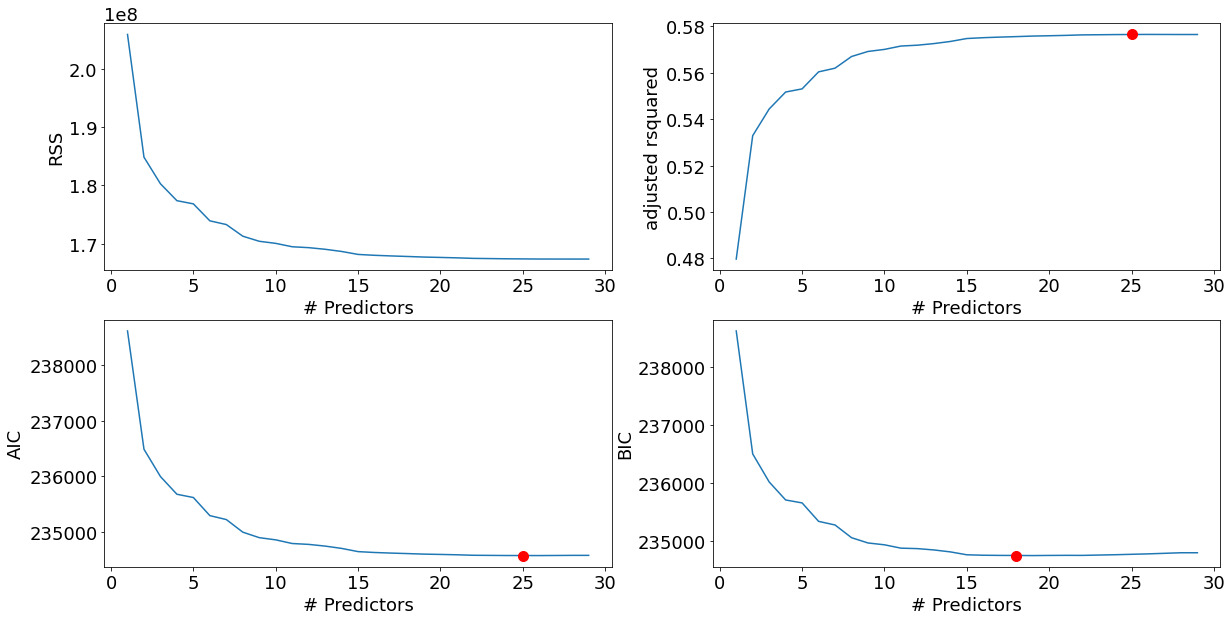

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
print(models_bwd.loc[20, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:             Appliances   R-squared (uncentered):                   0.576
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              1341.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:05:13   Log-Likelihood:                     -1.1728e+05
No. Observations:               19735   AIC:                                  2.346e+05
Df Residuals:                   19715   BIC:                                  2.348e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

BACKWARD ON DF_PCA

In [ ]:
from sklearn.model_selection import train_test_split


X = df_pca.iloc[:, 1:]
y = df_pca.iloc[:, 0]


#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  12 models on 11 predictors in 0.27882933616638184 seconds.
Processed  11 models on 10 predictors in 0.23154616355895996 seconds.
Processed  10 models on 9 predictors in 0.1840207576751709 seconds.
Processed  9 models on 8 predictors in 0.1706986427307129 seconds.
Processed  8 models on 7 predictors in 0.1206669807434082 seconds.
Processed  7 models on 6 predictors in 0.0953683853149414 seconds.
Processed  6 models on 5 predictors in 0.06910324096679688 seconds.
Processed  5 models on 4 predictors in 0.051506996154785156 seconds.
Processed  4 models on 3 predictors in 0.04068183898925781 seconds.
Processed  3 models on 2 predictors in 0.027411460876464844 seconds.
Processed  2 models on 1 predictors in 0.017734766006469727 seconds.
Total elapsed time: 1.3559925556182861 seconds.


Text(0, 0.5, 'BIC')

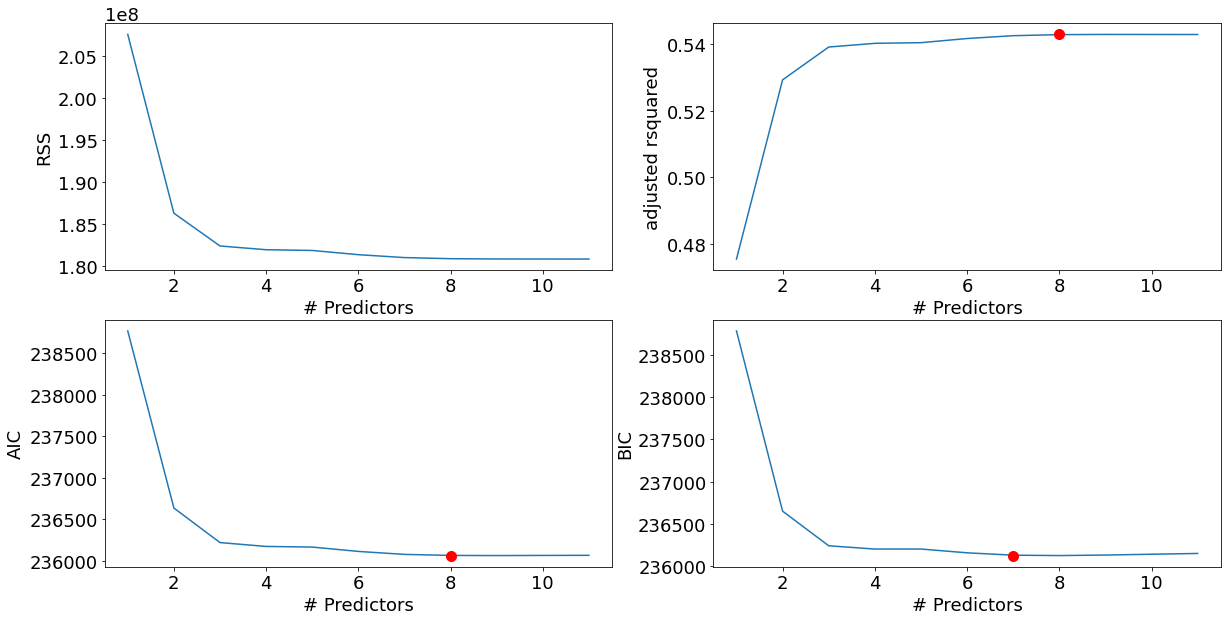

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
print(models_bwd.loc[8, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:             Appliances   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              2931.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:06:01   Log-Likelihood:                     -1.1802e+05
No. Observations:               19735   AIC:                                  2.361e+05
Df Residuals:                   19727   BIC:                                  2.361e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [ ]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,len(X.columns)+1):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 12 models on 1 predictors in 0.0711214542388916 seconds.
Processed 66 models on 2 predictors in 0.5968911647796631 seconds.
Processed 220 models on 3 predictors in 2.2010931968688965 seconds.
Processed 495 models on 4 predictors in 5.7814459800720215 seconds.
Processed 792 models on 5 predictors in 11.393690586090088 seconds.
Processed 924 models on 6 predictors in 15.68352723121643 seconds.
Processed 792 models on 7 predictors in 21.224380016326904 seconds.
Processed 495 models on 8 predictors in 10.69655179977417 seconds.
Processed 220 models on 9 predictors in 5.927183151245117 seconds.
Processed 66 models on 10 predictors in 1.410398006439209 seconds.
Processed 12 models on 11 predictors in 0.3058338165283203 seconds.
Processed 1 models on 12 predictors in 0.02894282341003418 seconds.
Total elapsed time: 76.23246550559998 seconds.


Text(0, 0.5, 'BIC')

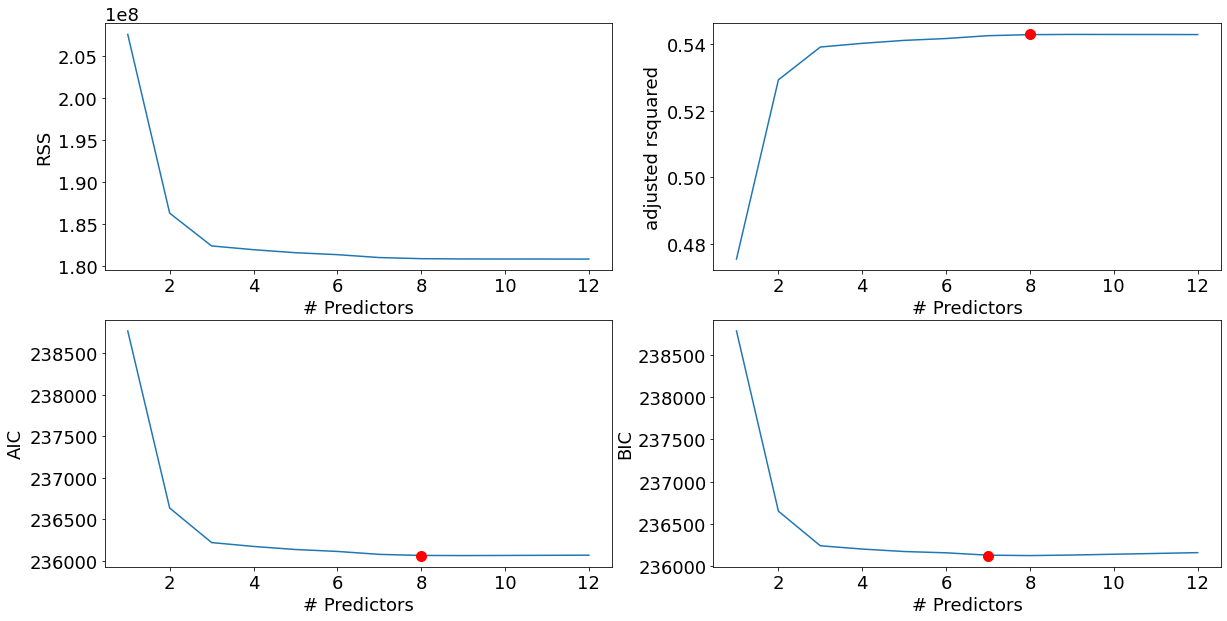

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
# show the best 5-variable model
print(getBest(8)["model"].summary())

Processed 495 models on 8 predictors in 13.972816944122314 seconds.
                                 OLS Regression Results                                
Dep. Variable:             Appliances   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              2931.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:18:02   Log-Likelihood:                     -1.1802e+05
No. Observations:               19735   AIC:                                  2.361e+05
Df Residuals:                   19727   BIC:                                  2.361e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>

BACKWARDS ON DF_AVERAGE

In [ ]:
from sklearn.model_selection import train_test_split


X = df_average.iloc[:, 1:]
y = df_average.iloc[:, 0]


#split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  12 models on 11 predictors in 0.34149742126464844 seconds.
Processed  11 models on 10 predictors in 0.34005141258239746 seconds.
Processed  10 models on 9 predictors in 0.21324682235717773 seconds.
Processed  9 models on 8 predictors in 0.18316197395324707 seconds.
Processed  8 models on 7 predictors in 0.14716458320617676 seconds.
Processed  7 models on 6 predictors in 0.12182259559631348 seconds.
Processed  6 models on 5 predictors in 0.09931230545043945 seconds.
Processed  5 models on 4 predictors in 0.0776510238647461 seconds.
Processed  4 models on 3 predictors in 0.04808163642883301 seconds.
Processed  3 models on 2 predictors in 0.035146236419677734 seconds.
Processed  2 models on 1 predictors in 0.02391362190246582 seconds.
Total elapsed time: 1.6813788414001465 seconds.


Text(0, 0.5, 'BIC')

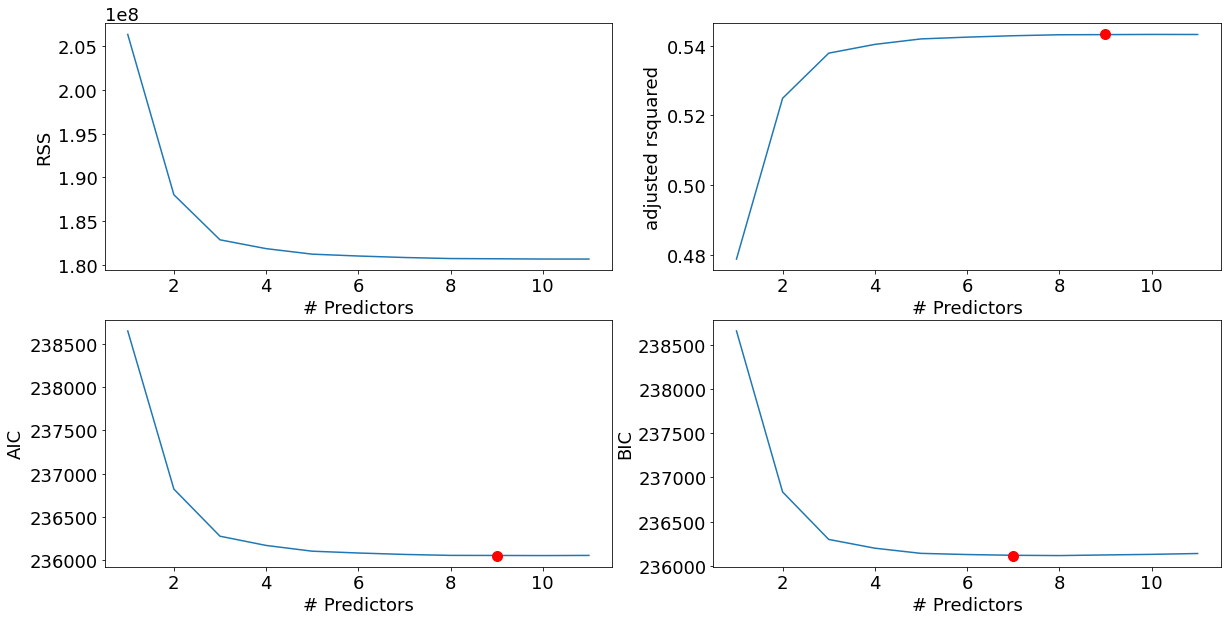

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
print(models_bwd.loc[9, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:             Appliances   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              2608.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                        0.00
Time:                        20:19:46   Log-Likelihood:                     -1.1802e+05
No. Observations:               19735   AIC:                                  2.361e+05
Df Residuals:                   19726   BIC:                                  2.361e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

#References:

Lasso Regression: https://www.geeksforgeeks.org/implementation-of-lasso-regression-from-scratch-using-python/

Linear Regression: https://www.geeksforgeeks.org/linear-regression-implementation-from-scratch-using-python/

Decision Tree and Random Forest: https://github.com/eriklindernoren/ML-From-Scratch/tree/master/mlfromscratch/supervised_learning

Backward Subset Selection: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html
